<a href="https://colab.research.google.com/github/davidfague/Stylized-ReducedOrder-L5-Model/blob/main/Stylized_Reduced_Order_L5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Neuron Initialization
Import modules and setup simulation parameters

In [1]:
!pip install neuron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Stylized-Cell-model/

/content/drive/MyDrive/Stylized-Cell-model


In [4]:
from neuron import h
import pandas as pd
import numpy as np
from scipy.stats import lognorm
import time as time
import os
from typing import Optional, List, Tuple, Union

In [5]:


from stylized_module.stylized_cell import Stylized_Cell
from stylized_module.ecp import EcpMod, newposition
from stylized_module.recorder import Recorder
from stylized_module.point_current import Point_current

mechanisms_path = 'mechanisms'  # need to compile the folder first
geometry_file = 'geom_parameters.csv'
tstop = 1000  # ms simulation duration
dt = 0.1  # ms. does not allow change

h.load_file('stdrun.hoc')
#h.nrn_load_dll(os.path.join(mechanisms_path,'nrnmech.dll'))  # running this line more than once might crash the kernel
h.nrn_load_dll(os.path.join(mechanisms_path,'x86_64/.libs/libnrnmech.so'))  # use this line instead in Linux
geo_standard = pd.read_csv(geometry_file,index_col='id')
h.tstop = tstop
h.dt = dt
h.steps_per_ms = 1/h.dt

In [6]:
#pick a random seed to initalize random values
import random
random.seed(427)
pi=np.pi

In [7]:
# def lognormal(m, s):
#         mean = np.log(m) - 0.5 * np.log((s/m)**2+1)
#         std = np.sqrt(np.log((s/m)**2 + 1))
#         #import pdb; pdb.set_trace()
#         return max(np.random.lognormal(mean, std, 1), 0.00000001)

In [8]:
#get underlying normal distribution parameters from lognormal distribution parameters
m=.2
s=0.345
mean = np.log(m) - 0.5 * np.log((s/m)**2+1)
std = np.sqrt(np.log((s/m)**2 + 1))
print(mean)
print(std)

-2.299528896659566
1.1748114608101725


Define cell model and simulation model. Edit method "set_channels" to design biophysical properties.

In [9]:
loc_param = [50,0,10,0,1,0]  # example position #D: initially this was [0,0,50,0.2,0.75,1.5], (x,y,z,theta,h,phi), h=[-1,1] phi=[-pi,pi] h=.7071067812 for 90 deg
#note on parameters: Rotate(alpha,h,phi): first rotate alpha about y-axis (spin), then rotate arccos(h) about x-axis (elevation), then rotate phi about y axis (azimuth).


# change geo_parameters from their default values
geo_param = [ # -1 uses default value
            #soma
            -1,  # radius
#proximal trunk
            -1, # excitation ('TRUE'/'FALSE')
            -1, # inhibition ('TRUE'/'FALSE')
            -1, # length
            -1, # radius
            -1, # exc FR mean
            -1, # exc FR std
            -1, # inh FR mean
            -1, # inh FR std
            -1, # exc P_0 mean (0 to 1)
            -1, # exc P_0 std
            -1, # inh P_0 mean (0 to 1)
            -1, # inh P_0 std
#middle trunk
            -1, # excitation ('TRUE'/'FALSE')
            -1, # inhibition ('TRUE'/'FALSE')
            -1, # length
            -1, # radius
            -1, # exc FR mean
            -1, # exc FR std
            -1, # inh FR mean
            -1, # inh FR std
            -1, # exc P_0 mean (0 to 1)
            -1, # exc P_0 std
            -1, # inh P_0 mean (0 to 1)
            -1, # inh P_0 std
#distal trunk
            -1, # excitation ('TRUE'/'FALSE')
            -1, # inhibition ('TRUE'/'FALSE')
            -1, # length
            -1, # radius
            -1, # exc FR mean
            -1, # exc FR std
            -1, # inh FR mean
            -1, # inh FR std
            -1, # exc P_0 mean (0 to 1)
            -1, # exc P_0 std
            -1, # inh P_0 mean (0 to 1)
            -1, # inh P_0 std
#basal dendrites
            -1, # excitation ('TRUE'/'FALSE')
            -1, # inhibition ('TRUE'/'FALSE')
            -1, # number of dendrites
            -1, # proximal section length
            -1, # middle section length
            -1, # distal section length
            -1, # radius
            -1, # angle
            -1, # exc FR mean
            -1, # exc FR std
            -1, # inh FR mean
            -1, # inh FR std
            -1, # exc P_0 mean (0 to 1)
            -1, # exc P_0 std
            -1, # inh P_0 mean (0 to 1)
            -1, # inh P_0 std
#oblique dendrites
            -1, # excitation ('TRUE'/'FALSE')
            -1, # inhibition ('TRUE'/'FALSE')
            -1, # number of dendrites
            -1, # length
            -1, # radius
            -1, # angle
            -1, # exc FR mean
            -1, # exc FR std
            -1, # inh FR mean
            -1, # inh FR std
            -1, # exc P_0 mean (0 to 1)
            -1, # exc P_0 std
            -1, # inh P_0 mean (0 to 1)
            -1, # inh P_0 std
#tuft dendrites
            -1, # excitation ('TRUE'/'FALSE')
            -1, # inhibition ('TRUE'/'FALSE')
            -1, # number of dendrites
            -1, # proximal section length
            -1, # middle section length
            -1, # distal section length
            -1, # radius
            -1, # angle
            -1, # exc FR mean
            -1, # exc FR std
            -1, # inh FR mean
            -1, # inh FR std
            -1, # exc P_0 mean (0 to 1)
            -1, # exc P_0 std
            -1, # inh P_0 mean (0 to 1)
            -1, # inh P_0 std
#axon
            60, # length
            2, # radius # hay uses 0.5 #we had at 8
#passive basal
            -1, # number of dendrites
            -1, # length
            -1 # radius
        ]
      
      
# example of changing biophysical parameters (check "biophys_entries" in "Cell" class for meaning, bounds can also be found there)
biophys = [0.0000300,0.0000300,0.0000489,0.0000589,0.0000589,0.0000300,0.0000100, ## g_pas of soma, basal, midTrunk, distal trunk, and tuft, axon, passive dendrites
                                    0.998912,0.0213,0.0213,0.0213,0.0213,3.89618,0.002, # gNaTa_t of soma, basal, midTrunk, distal trunk, and tuft
                                    0.693,0.000261,0.000261,0.000261,0.000261,0.473799,0.00002, # gSKv3_1 of soma, basal, midTrunk, distal trunk, and tuft
                                    0.000992,0.000992,0.00001,0.00352,0.00001,0.000222,0.00001,  # gCA_HVA of soma, basal, distal trunk
                                    0.00343,0.00343,0.00001,0.104,0.00001,0.000813,0.00001, # gCA_LVAst of soma, basal, distal trunk
                                    0.0000675,0.0000675,0.0000675,0.0000675,0.013322, # gIm of basal, mid trunk, distal trunk, and tuft 
                                    460.0,122,122,122,122,277.300774,122, # decay_CaDynamics of soma, basal, mid trunk, distal trunk, and tuft
                                    0.000501,0.000509,0.000509,0.000509,0.000509,0.000525,0.000509, # gamma_CaDynamics of soma, basal, mid trunk, distal trunk, and tuft
                                    0.0002,0.0002,0.0002,0.0002,0.0002,0.0001,0.0001, # gIh of soma, basal, midTrunk, distal trunk, and tuft
                                    0.0441,0.0012,0.0012,0.0012,0.0012,0.000047, # gSk_E2 of soma, basal, midTrunk, distal trunk, and tuft
                                    0.0812,0.077274, # gK_Tst of soma
                                    0.00223,0.188851, # gK_Pst of soma
                                    0.005834 # gNap_Et2 of soma
                                    ]
sim = Simulation(geo_standard,elec_pos,loc_param,geo_param=geo_param,biophys=biophys,gmaxEXC=0.07,gmaxINH=0.05,scale=100.,exc_dens=2.16,inh_dens=0.22,spike_threshold = 10)  # 0.001 -0.012 #gmax=.005, scale=100


#### Create simulation

In [10]:
x = np.zeros(96)
y = np.linspace(-1900,1900,96)
z = np.zeros(96)
elec_pos = pos = np.column_stack((x,y,z))

Set parameters

In [11]:
loc_param = [50,0,10,0,1,0]  # example position #D: initially this was [0,0,50,0.2,0.75,1.5], (x,y,z,theta,h,phi), h=[-1,1] phi=[-pi,pi] h=.7071067812 for 90 deg
#note on parameters: Rotate(alpha,h,phi): first rotate alpha about y-axis (spin), then rotate arccos(h) about x-axis (elevation), then rotate phi about y axis (azimuth).


# change geo_parameters from their default values
geo_param = [ # -1 uses default value
            #soma
            -1,  # radius
#proximal trunk
            -1, # excitation ('TRUE'/'FALSE')
            -1, # inhibition ('TRUE'/'FALSE')
            -1, # length
            -1, # radius
            -1, # exc FR mean
            -1, # exc FR std
            -1, # inh FR mean
            -1, # inh FR std
            -1, # exc P_0 mean (0 to 1)
            -1, # exc P_0 std
            -1, # inh P_0 mean (0 to 1)
            -1, # inh P_0 std
#middle trunk
            -1, # excitation ('TRUE'/'FALSE')
            -1, # inhibition ('TRUE'/'FALSE')
            -1, # length
            -1, # radius
            -1, # exc FR mean
            -1, # exc FR std
            -1, # inh FR mean
            -1, # inh FR std
            -1, # exc P_0 mean (0 to 1)
            -1, # exc P_0 std
            -1, # inh P_0 mean (0 to 1)
            -1, # inh P_0 std
#distal trunk
            -1, # excitation ('TRUE'/'FALSE')
            -1, # inhibition ('TRUE'/'FALSE')
            -1, # length
            -1, # radius
            -1, # exc FR mean
            -1, # exc FR std
            -1, # inh FR mean
            -1, # inh FR std
            -1, # exc P_0 mean (0 to 1)
            -1, # exc P_0 std
            -1, # inh P_0 mean (0 to 1)
            -1, # inh P_0 std
#basal dendrites
            -1, # excitation ('TRUE'/'FALSE')
            -1, # inhibition ('TRUE'/'FALSE')
            -1, # number of dendrites
            -1, # proximal section length
            -1, # middle section length
            -1, # distal section length
            -1, # radius
            -1, # angle
            -1, # exc FR mean
            -1, # exc FR std
            -1, # inh FR mean
            -1, # inh FR std
            -1, # exc P_0 mean (0 to 1)
            -1, # exc P_0 std
            -1, # inh P_0 mean (0 to 1)
            -1, # inh P_0 std
#oblique dendrites
            -1, # excitation ('TRUE'/'FALSE')
            -1, # inhibition ('TRUE'/'FALSE')
            -1, # number of dendrites
            -1, # length
            -1, # radius
            -1, # angle
            -1, # exc FR mean
            -1, # exc FR std
            -1, # inh FR mean
            -1, # inh FR std
            -1, # exc P_0 mean (0 to 1)
            -1, # exc P_0 std
            -1, # inh P_0 mean (0 to 1)
            -1, # inh P_0 std
#tuft dendrites
            -1, # excitation ('TRUE'/'FALSE')
            -1, # inhibition ('TRUE'/'FALSE')
            -1, # number of dendrites
            -1, # proximal section length
            -1, # middle section length
            -1, # distal section length
            -1, # radius
            -1, # angle
            -1, # exc FR mean
            -1, # exc FR std
            -1, # inh FR mean
            -1, # inh FR std
            -1, # exc P_0 mean (0 to 1)
            -1, # exc P_0 std
            -1, # inh P_0 mean (0 to 1)
            -1, # inh P_0 std
#axon
            60, # length
            2, # radius # hay uses 0.5 #we had at 8
#passive basal
            -1, # number of dendrites
            -1, # length
            -1 # radius
        ]
      
      
# example of changing biophysical parameters (check "biophys_entries" in "Cell" class for meaning, bounds can also be found there)
biophys = [0.0000300,0.0000300,0.0000489,0.0000589,0.0000589,0.0000300,0.0000100, ## g_pas of soma, basal, midTrunk, distal trunk, and tuft, axon, passive dendrites
                                    0.998912,0.0213,0.0213,0.0213,0.0213,3.89618,0.002, # gNaTa_t of soma, basal, midTrunk, distal trunk, and tuft
                                    0.693,0.000261,0.000261,0.000261,0.000261,0.473799,0.00002, # gSKv3_1 of soma, basal, midTrunk, distal trunk, and tuft
                                    0.000992,0.000992,0.00001,0.00352,0.00001,0.000222,0.00001,  # gCA_HVA of soma, basal, distal trunk
                                    0.00343,0.00343,0.00001,0.104,0.00001,0.000813,0.00001, # gCA_LVAst of soma, basal, distal trunk
                                    0.0000675,0.0000675,0.0000675,0.0000675,0.013322, # gIm of basal, mid trunk, distal trunk, and tuft 
                                    460.0,122,122,122,122,277.300774,122, # decay_CaDynamics of soma, basal, mid trunk, distal trunk, and tuft
                                    0.000501,0.000509,0.000509,0.000509,0.000509,0.000525,0.000509, # gamma_CaDynamics of soma, basal, mid trunk, distal trunk, and tuft
                                    0.0002,0.0002,0.0002,0.0002,0.0002,0.0001,0.0001, # gIh of soma, basal, midTrunk, distal trunk, and tuft
                                    0.0441,0.0012,0.0012,0.0012,0.0012,0.000047, # gSk_E2 of soma, basal, midTrunk, distal trunk, and tuft
                                    0.0812,0.077274, # gK_Tst of soma
                                    0.00223,0.188851, # gK_Pst of soma
                                    0.005834 # gNap_Et2 of soma
                                    ]
sim = Simulation(geo_standard,elec_pos,loc_param,geo_param=geo_param,biophys=biophys,gmaxEXC=0.07,gmaxINH=0.05,scale=100.,exc_dens=2.16,inh_dens=0.22,spike_threshold = 10)  # 0.001 -0.012 #gmax=.005, scale=100


disttrunk has no synapses
axon has no synapses
passivebasal has no synapses


In [12]:
SecD_list=[]
for id,sec in sim.cells[0].geometry.iterrows():
  sec_index_list=sim.cells[0].sec_id_lookup[id]
  D = sec['R']*2
  if sec['axial']:
    SecD_list.append(D)
  else:
    SecD_list.append(D)
    SecD_list.append(D)
    SecD_list.append(D)
    SecD_list.append(D)
print(SecD_list)

SecL_list=[]
for id,sec in sim.cells[0].geometry.iterrows():
  sec_index_list=sim.cells[0].sec_id_lookup[id]
  L = sec['L']
  if sec['axial']:
    SecL_list.append(L)
  else:
    SecL_list.append(L)
    SecL_list.append(L)
    SecL_list.append(L)
    SecL_list.append(L)
print(SecL_list)

[20.0, 1.4, 1.4, 1.4, 1.4, 0.65, 0.65, 0.65, 0.65, 0.6, 0.6, 0.6, 0.6, 8.0, 1.231048, 1.231048, 1.231048, 1.231048, 2.512856, 1.233552, 0.5441728, 0.5441728, 0.5441728, 0.5441728, 0.5441728, 0.5441728, 0.5441728, 0.5441728, 0.5441728, 0.5441728, 0.5441728, 0.5441728, 4.0, 1.6, 1.6, 1.6, 1.6]
[0, 40, 40, 40, 40, 60, 60, 60, 60, 100, 100, 100, 100, 200, 200, 200, 200, 200, 425, 75, 100, 100, 100, 100, 200, 200, 200, 200, 200, 200, 200, 200, 60, 45, 45, 45, 45]


In [13]:
print('The number of synapses in the detailed model is 29028')
print('The number of synapses in the reduced-order model is',len(sim.cells[0].injection))
syn_reduce = (len(sim.cells[0].injection)/29028)
print('The number of synapses has been reduced by a factor of',(syn_reduce))
print('The number of segments in the detailed model is 13962')
print('The number of segments in the reduced-order model is',len(sim.cells[0].segments))
seg_reduce = (len(sim.cells[0].segments)/13962)
print('The number of segments has been reduced by a factor of',(seg_reduce))

# Ben's detailed L5
# Excitatory: 16070 on apical dendrites (2.16 syns/um * 7440 um)
# 10042 (2.16 syns/um * 4649 um) on basal dendrites. 
# Inhibitory: 150 on soma  (Egger et al., 2020; Markram et al., 2015; Reimann et al., 2015) + (0.22 syns/um *483 um) = 256 perisomatic, 
# 1637 (0.22 syns/um * 7440 um)  on apical dendrites, 
# 1023 (0.22 syns/um * 4649 um) on basal dendrites.

# total is 29028

#note: 
# Ben's apical to basal length & apical to basal synapse ratio is 1.6003 (7440um/4649um)

The number of synapses in the detailed model is 29028
The number of synapses in the reduced-order model is 9544
The number of synapses has been reduced by a factor of 0.32878599972440403
The number of segments in the detailed model is 13962
The number of segments in the reduced-order model is 168
The number of segments has been reduced by a factor of 0.012032660077352814


Record membrane voltage at initial/middle/end of the trunk and middle of the tuft to check the propagation.

In [14]:
nseg = len(sim.cells[0].segments)
print(nseg)
numTstep = int(h.tstop/h.dt)

seg_list = sim.cells[0].get_seg_by_id(range(nseg))
#print(seg_list)

Vrecord = []
for i in range(0,len(seg_list)):
     Vrecord.append(seg_list[i])

dend_v = Recorder(Vrecord)

168


In [15]:
def returnSegmentValues(section, secnum):
    ##
    
    #Set impedance measurement location and frequency
   
    zz = h.Impedance()
    zz.loc(sim.cells[0].get_sec_by_id([0])[0](0.5))
    zz.compute(25)

    # Get section 3d coordinates and put in numpy array
    n3d = section.n3d()
    x3d = np.empty(n3d)
    y3d = np.empty(n3d)
    z3d = np.empty(n3d)
    L = np.empty(n3d)
    for i in range(n3d):
        x3d[i]=section.x3d(i)
        y3d[i]=section.y3d(i)
        z3d[i]=section.z3d(i)

    # Compute length of each 3d segment
    for i in range(n3d):
        if i==0:
            L[i]=0
        else:
            L[i]=np.sqrt((x3d[i]-x3d[i-1])**2 + (y3d[i]-y3d[i-1])**2 + (z3d[i]-z3d[i-1])**2)

    # Get cumulative length of 3d segments
    cumLength = np.cumsum(L)
    N = section.nseg
    
    # Now upsample coordinates to segment locations
    xCoord = np.empty(N)
    yCoord = np.empty(N)
    zCoord = np.empty(N)
    Elec_distance = np.empty(N)
    SecNum = np.empty(N)

    if N > 1:
      dx = section.L / (N-1)
    else:
      dx = section.L
    for n in range(N):
        Elec_distance[n] = zz.ratio(section((n*dx)/cumLength[1]))
        SecNum[n] = secnum
        if n==N-1: 
            xCoord[n]=x3d[-1]
            yCoord[n]=y3d[-1]
            zCoord[n]=z3d[-1]
        else:
            cIdxStart = np.where(n*dx >= cumLength)[0][-1] # which idx of 3d segments are we starting at
            cDistFrom3dStart = n*dx - cumLength[cIdxStart] # how far along that segment is this upsampled coordinate
            cFraction3dLength = cDistFrom3dStart / L[cIdxStart+1] # what's the fractional distance along this 3d segment
            # compute x and y positions
            xCoord[n] = x3d[cIdxStart] + cFraction3dLength*(x3d[cIdxStart+1] - x3d[cIdxStart])
            yCoord[n] = y3d[cIdxStart] + cFraction3dLength*(y3d[cIdxStart+1] - y3d[cIdxStart])
            zCoord[n] = z3d[cIdxStart] + cFraction3dLength*(z3d[cIdxStart+1] - z3d[cIdxStart])
            
    return SecNum, xCoord, yCoord, zCoord, Elec_distance

In [16]:
sec_list = sim.cells[0].get_sec_by_id(range(len(sim.cells[0].all)))

section = []
SectionXCoord = []
SectionYCoord = []
SectionZCoord = []
SectionElecDist = []
AllSegSection = []
AllSegXCoord = []
AllSegYCoord = []
AllSegZCoord = []
AllSegElecDist = []
for i in range(1,len(sec_list)):

  section, SectionXCoord, SectionYCoord, SectionZCoord, SectionElecDist = returnSegmentValues(sec_list[i], i)

  AllSegSection.extend(section)
  AllSegXCoord.extend(SectionXCoord)
  AllSegYCoord.extend(SectionYCoord)
  AllSegZCoord.extend(SectionZCoord)
  AllSegElecDist.extend(SectionElecDist)



  if str(sec_list[i]) == 'disttrunk':
    nexus_seg = round(len(AllSegSection) - (len(section)/2))
  
  if str(sec_list[i]) == 'axon':
    axon_seg = round(len(AllSegSection) - (len(section)/2))

  if str(sec_list[i]) == 'disttuft':
    dist_tuft_seg = round(len(AllSegSection) - (len(section)/2))

  if str(sec_list[i]) == 'distbasal':
    dist_basal_seg = round(len(AllSegSection) - (len(section)/2))

  if str(sec_list[i]) == 'oblique':
    oblique_seg = round(len(AllSegSection) - (len(section)/2))
    



In [17]:
gNaTa_T = Recorder(obj_list = sim.cells[0].segments, var_name = 'gNaTa_t_NaTa_t')

In [18]:
ical = Recorder(obj_list = sim.cells[0].segments, var_name = 'ica_Ca_LVAst')
icah = Recorder(obj_list = sim.cells[0].segments, var_name = 'ica_Ca_HVA')

In [19]:
ih = Recorder(obj_list = sim.cells[0].segments, var_name = 'ihcn_Ih')


In [20]:
timestart=time.time()
sim.run()
timestop=time.time()
lfp = sim.get_lfp().T
t = sim.t()

In [21]:
elapsedtime=timestop-timestart
simtime=tstop/1000 #convert from ms to s
print('It took',round(elapsedtime),'sec to run a',simtime,'sec simulation.')

It took 61 sec to run a 1.0 sec simulation.


In [22]:
numSyn = len(sim.cells[0].injection)

excSynPerSeg = [0]*nseg
inhSynPerSeg = [0]*nseg

i_NMDA_bySeg= [[0] * (numTstep+1) ] * nseg

print(len(sim.cells[0].injection))

for j in range(numSyn):
  seg = sim.cells[0].injection[j].get_segment_id()
  if(sim.cells[0].injection[j].syntype == 'exc'):
    excSynPerSeg[seg] += 1
  else:
    inhSynPerSeg[seg] += 1

  try:
    i_NMDA = np.array(sim.cells[0].injection[j].rec_vec.vec_list[1])            #current = numpy array of NEURON Vector of current NMDA current at synapse j  
    seg = sim.cells[0].injection[j].get_segment_id()                            #seg = the segment in which synapse j is located 
    #print('first try')
    
    try:
      i_NMDA_bySeg[seg] = i_NMDA_bySeg[seg] + i_NMDA    
      #print('second try')                                           #Sum current over each segment
    except: 
      x = j                                                                     #Except needed as some synpases do not have NMDA currrent and throw an error when called
  except:
    x = j

9544


In [23]:
ih_data = ih.as_numpy()
gNaTa_T_data = gNaTa_T.as_numpy()
icah_data = icah.as_numpy()
ical_data = ical.as_numpy()

In [24]:
spikes = sim.get_spike_time()

print(len(spikes)* (1000/tstop))

12.0


# File Output

In [25]:
import h5py

try:
  os.remove("Segments.hdf5")
except:
  x = 1

f0 = h5py.File("Segments.hdf5", "w")

segs = f0.create_dataset("Segs", data= list(range(nseg-1)))
X = f0.create_dataset("X", data = AllSegXCoord)
Y = f0.create_dataset("Y", data = AllSegYCoord)
sec = f0.create_dataset("sec", data = AllSegSection)
neSyn = f0.create_dataset("neSyn", data= excSynPerSeg)
niSyn = f0.create_dataset("niSyn", data= inhSynPerSeg)
elec_dist = f0.create_dataset("elec_dist", data = AllSegElecDist)

f0.close()

In [26]:
try:
  os.remove("Spikes.hdf5")
except:
  x = 1

f01 = h5py.File("Spikes.hdf5", "w")

spikes = f01.create_dataset("spikes", data= spikes)

f01.close()

In [27]:
v_dend = dend_v.as_numpy()
# Voltage output

try:
  os.remove("v_report.hdf5")
except:
  x = 1

f1 = h5py.File("v_report.hdf5", "w")

voltage = f1.create_dataset("v", data= v_dend)
time = f1.create_dataset("t", data = t)

f1.close()

In [28]:
#NMDA output

try:
  os.remove("i_nmda_report.hdf5")
except:
  x = 1
  
f2 = h5py.File("i_nmda_report.hdf5", "w")

i_NMDA = f2.create_dataset("i_nmda", data = i_NMDA_bySeg)

f2.close()


In [29]:
#gNaTa output

try:
  os.remove("gNaTa_report.hdf5")
except:
  x = 1
  
f6 = h5py.File("gNaTa_report.hdf5", "w")

gNaTa = f6.create_dataset("gNaTa", data = gNaTa_T_data ) # dtype= np.float

f6.close()

In [30]:
#Calcium output
try:
  os.remove("i_CaHva_report.hdf5")
  os.remove("i_CaLva_report.hdf5")
except:
  x = 1
  
f3 = h5py.File("i_CaHva_report.hdf5", "w")
f4 = h5py.File("i_CaLva_report.hdf5", "w")

i_CaHva = f3.create_dataset("i_CaHva", data = icah_data)
i_CaLva = f4.create_dataset("i_CaLva", data = ical_data)

f3.close()
f4.close()

In [31]:
#Ih output
try:
  os.remove("ihcn_report.dhf5")
except:
  x = 1
  
f5 = h5py.File("ihcn_report.hdf5", "w")

ihcn = f5.create_dataset("ihcn", data = ih_data)

f5.close()

# Plots

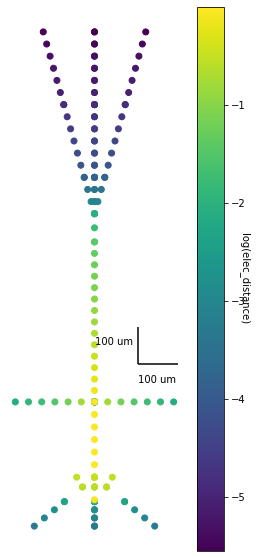

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(4,10))
ax = plt.scatter(AllSegXCoord, AllSegYCoord, c = np.log(AllSegElecDist) )
plt.vlines(110,300,400)
plt.text(0,350,'100 um')
plt.hlines(300,110,210)
plt.text(110,250,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

plt.box(False)
plt.savefig('Elec_distance.svg')

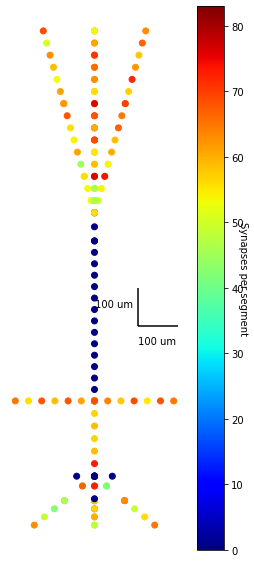

In [33]:
plt.figure(figsize=(4,10))
ax = plt.scatter(AllSegXCoord, AllSegYCoord,c = excSynPerSeg[0:(nseg-1)],cmap='jet',)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Synapses per segment', rotation=270)

plt.box(False)
plt.savefig('exc_syns.svg')

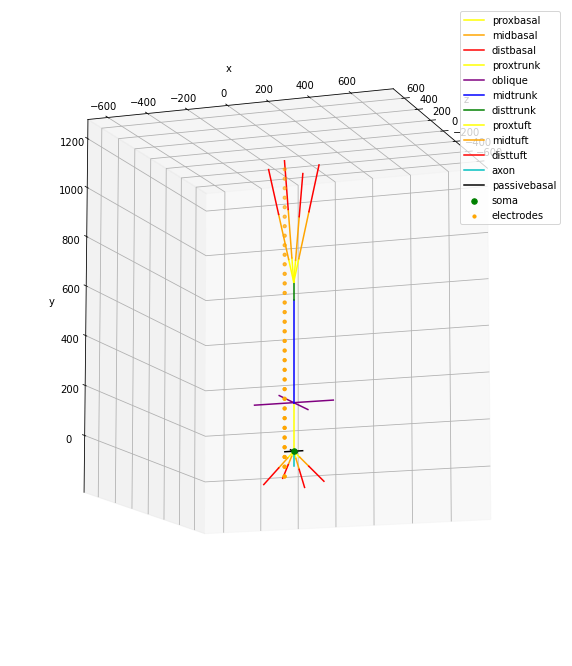

(<Figure size 720x864 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7f75ac2d7590>)

In [34]:
from utils.plot_results import plot_LFP_traces,plot_LFP_heatmap
from utils.plot_morphology import plot_morphology
plot_morphology(sim,electrodes=elec_pos,elev=-10, azim=20, figsize=(10,12), clr = ['g',       #soma
                                                                                   'yellow',  #proxbasal
                                                                                   'orange',  #midbasal
                                                                                   'red',     #distbasal
                                                                                   'yellow',  #proxtrunk
                                                                                   'purple',  #oblique
                                                                                   'blue',    #midtrunk
                                                                                   'green',   #disttrunk
                                                                                   'yellow',  #proxtuft
                                                                                   'orange',  #midtuft
                                                                                   'red',     #disttuft
                                                                                   'c',       #axon
                                                                                   'black'])  #passivebasal

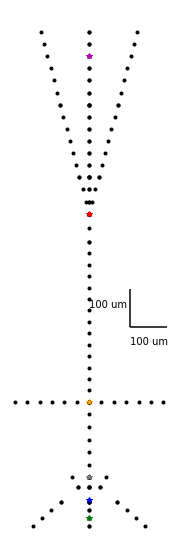

In [35]:
plt.figure(figsize=(3,10))
ax = plt.plot(AllSegXCoord, AllSegYCoord,'.',color='k',markersize=6)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
plt.box(False)

soma_probe = 0

plt.plot(AllSegXCoord[soma_probe], 
         AllSegYCoord[soma_probe],
         '*',color='grey')

plt.plot(AllSegXCoord[nexus_seg], 
         AllSegYCoord[nexus_seg],
         'r*')
plt.plot(AllSegXCoord[axon_seg], 
         AllSegYCoord[axon_seg],
         'b*')
plt.plot(AllSegXCoord[dist_tuft_seg], 
         AllSegYCoord[dist_tuft_seg],
         'm*')
plt.plot(AllSegXCoord[dist_basal_seg], 
         AllSegYCoord[dist_basal_seg],
         'g*')
plt.plot(AllSegXCoord[oblique_seg], 
         AllSegYCoord[oblique_seg],
         '*',color='orange')

#plt.savefig('fig1A.svg')

([], <a list of 0 Text major ticklabel objects>)

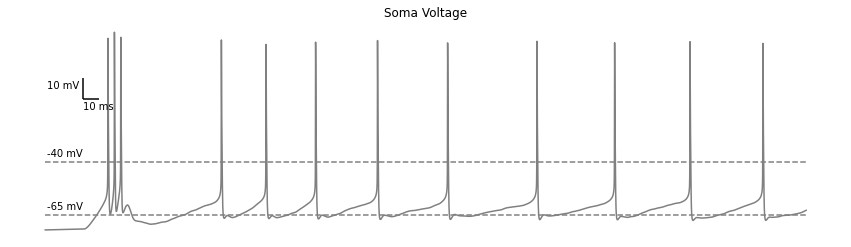

In [36]:
plt.figure(figsize=(15,4))
plt.plot(np.arange(0,((h.tstop)+.1),.1),v_dend[soma_probe],color='grey')
plt.hlines(-65,0,1000, color = 'grey', linestyle = 'dashed')
plt.hlines(-40,0,1000, color = 'grey', linestyle = 'dashed')
plt.hlines(-10,50,70)
plt.vlines(50,-10,0)
plt.text(50,-15,'10 ms')
plt.text(2,-5,'10 mV')
plt.text(2,-37,'-40 mV')
plt.text(2,-62,'-65 mV')
plt.title('Soma Voltage')
plt.box(False)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

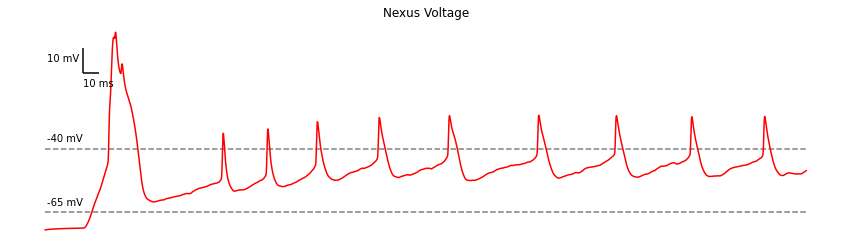

In [37]:
plt.figure(figsize=(15,4))
plt.plot(np.arange(0,((h.tstop)+.1),.1),v_dend[nexus_seg],color='r')
plt.hlines(-65,0,1000, color = 'grey', linestyle = 'dashed')
plt.hlines(-40,0,1000, color = 'grey', linestyle = 'dashed')
plt.hlines(-10,50,70)
plt.vlines(50,-10,0)
plt.text(50,-15,'10 ms')
plt.text(2,-5,'10 mV')
plt.text(2,-37,'-40 mV')
plt.text(2,-62,'-65 mV')
plt.title('Nexus Voltage')
plt.box(False)
plt.xticks([])
plt.yticks([])


([], <a list of 0 Text major ticklabel objects>)

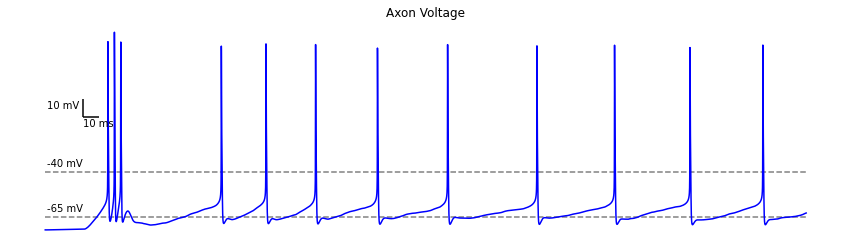

In [38]:
plt.figure(figsize=(15,4))
plt.plot(np.arange(0,((h.tstop)+.1),.1),v_dend[axon_seg],color='b')
plt.hlines(-65,0,1000, color = 'grey', linestyle = 'dashed')
plt.hlines(-40,0,1000, color = 'grey', linestyle = 'dashed')
plt.hlines(-10,50,70)
plt.vlines(50,-10,0)
plt.text(50,-15,'10 ms')
plt.text(2,-5,'10 mV')
plt.text(2,-37,'-40 mV')
plt.text(2,-62,'-65 mV')
plt.title('Axon Voltage')
plt.box(False)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

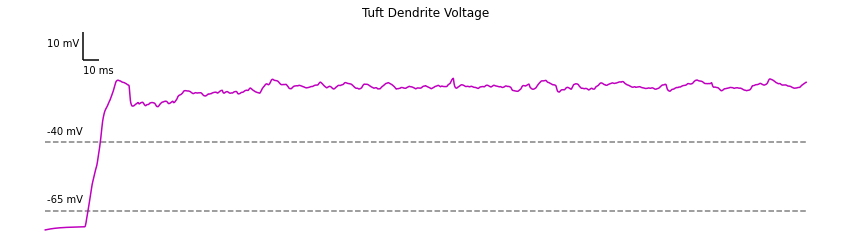

In [39]:
plt.figure(figsize=(15,4))
plt.plot(np.arange(0,((h.tstop)+.1),.1),v_dend[dist_tuft_seg],color='m')
plt.hlines(-65,0,1000, color = 'grey', linestyle = 'dashed')
plt.hlines(-40,0,1000, color = 'grey', linestyle = 'dashed')
plt.hlines(-10,50,70)
plt.vlines(50,-10,0)
plt.text(50,-15,'10 ms')
plt.text(2,-5,'10 mV')
plt.text(2,-37,'-40 mV')
plt.text(2,-62,'-65 mV')
plt.title('Tuft Dendrite Voltage')
plt.box(False)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

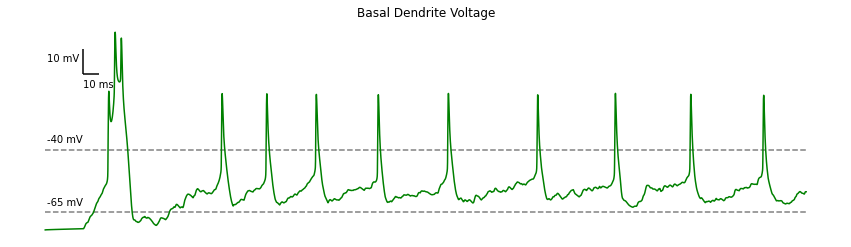

In [40]:
plt.figure(figsize=(15,4))
plt.plot(np.arange(0,((h.tstop)+.1),.1),v_dend[dist_basal_seg],color='g')
plt.hlines(-65,0,1000, color = 'grey', linestyle = 'dashed')
plt.hlines(-40,0,1000, color = 'grey', linestyle = 'dashed')
plt.hlines(-10,50,70)
plt.vlines(50,-10,0)
plt.text(50,-15,'10 ms')
plt.text(2,-5,'10 mV')
plt.text(2,-37,'-40 mV')
plt.text(2,-62,'-65 mV')
plt.title('Basal Dendrite Voltage')
plt.box(False)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

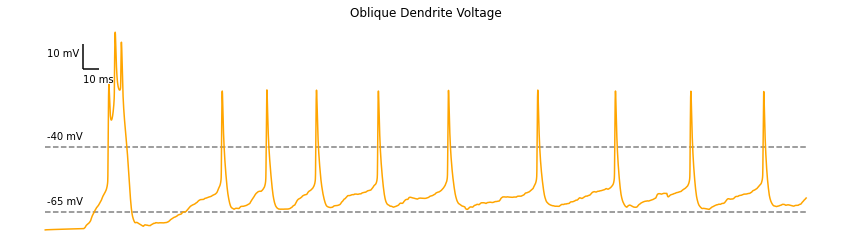

In [41]:
plt.figure(figsize=(15,4))
plt.plot(np.arange(0,((h.tstop)+.1),.1),v_dend[oblique_seg],color='orange')
plt.hlines(-65,0,1000, color = 'grey', linestyle = 'dashed')
plt.hlines(-40,0,1000, color = 'grey', linestyle = 'dashed')
plt.hlines(-10,50,70)
plt.vlines(50,-10,0)
plt.text(50,-15,'10 ms')
plt.text(2,-5,'10 mV')
plt.text(2,-37,'-40 mV')
plt.text(2,-62,'-65 mV')
plt.title('Oblique Dendrite Voltage')
plt.box(False)
plt.xticks([])
plt.yticks([])

The value after the section indicates the poroportional distance along the segment. 1 being distal from the soma and 0 being proximal to the soma.

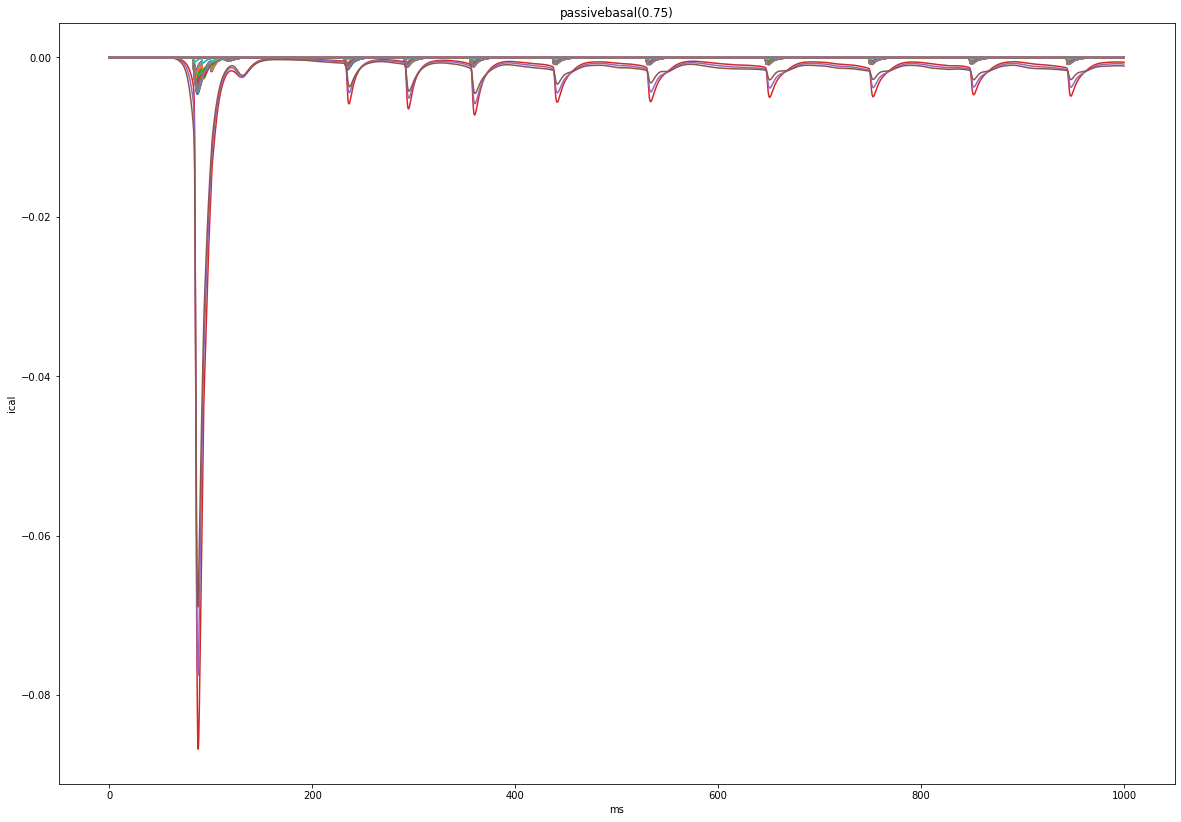

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline



# Ca LVA current 

plt.figure(figsize=(20,14))
for i in range(ical_data.shape[0]):
    plt.plot(t,ical_data[i,:])
    plt.title(Vrecord[i], loc='center')
    plt.ylabel('ical')
    plt.xlabel('ms')
plt.show()

In [43]:
sec14 = []
for i in range(nseg-1):
  if AllSegSection[i] == 12:
    sec14.append(i)

len(sec14)

4

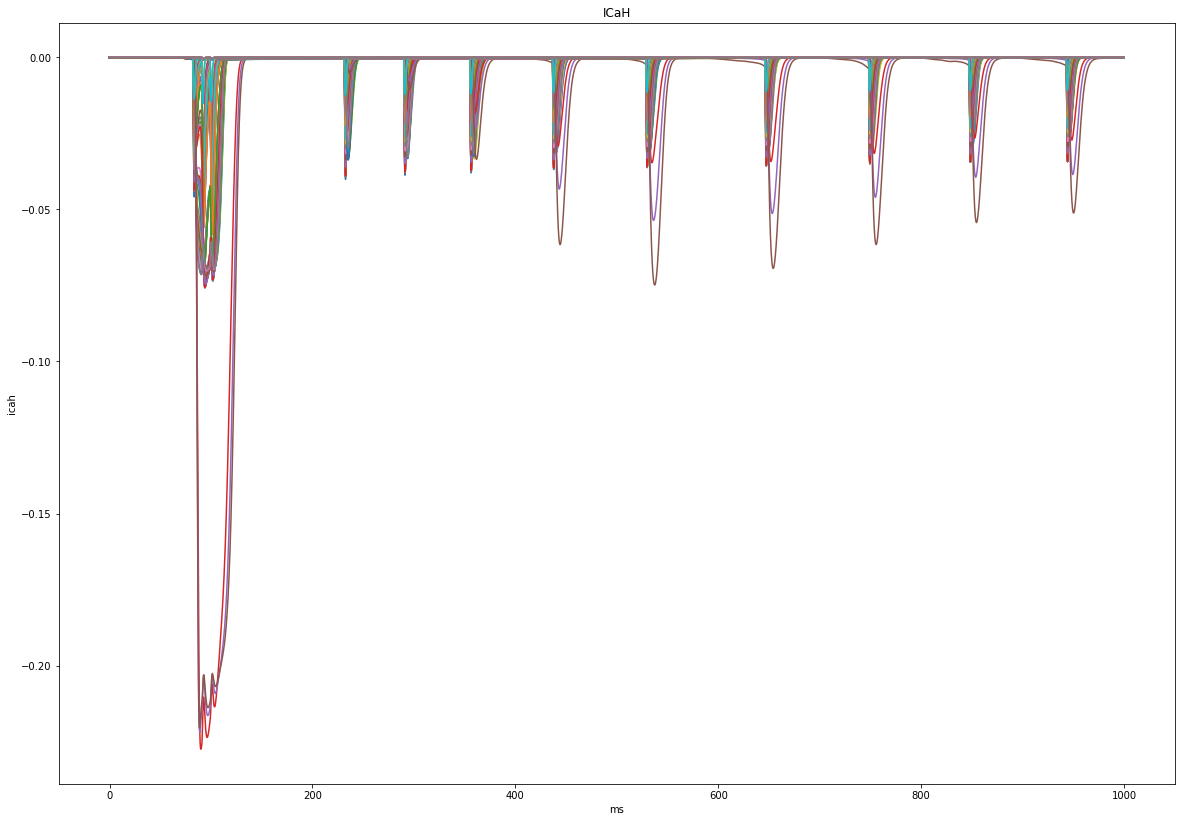

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline


# CA HVA current

plt.figure(figsize=(20,14))
for i in range(icah_data.shape[0]):
    plt.plot(t,icah_data[i,:])
    plt.title(Vrecord[i], loc='center')
    plt.ylabel('icah')
    plt.xlabel('ms')
    plt.title('ICaH')
plt.show()

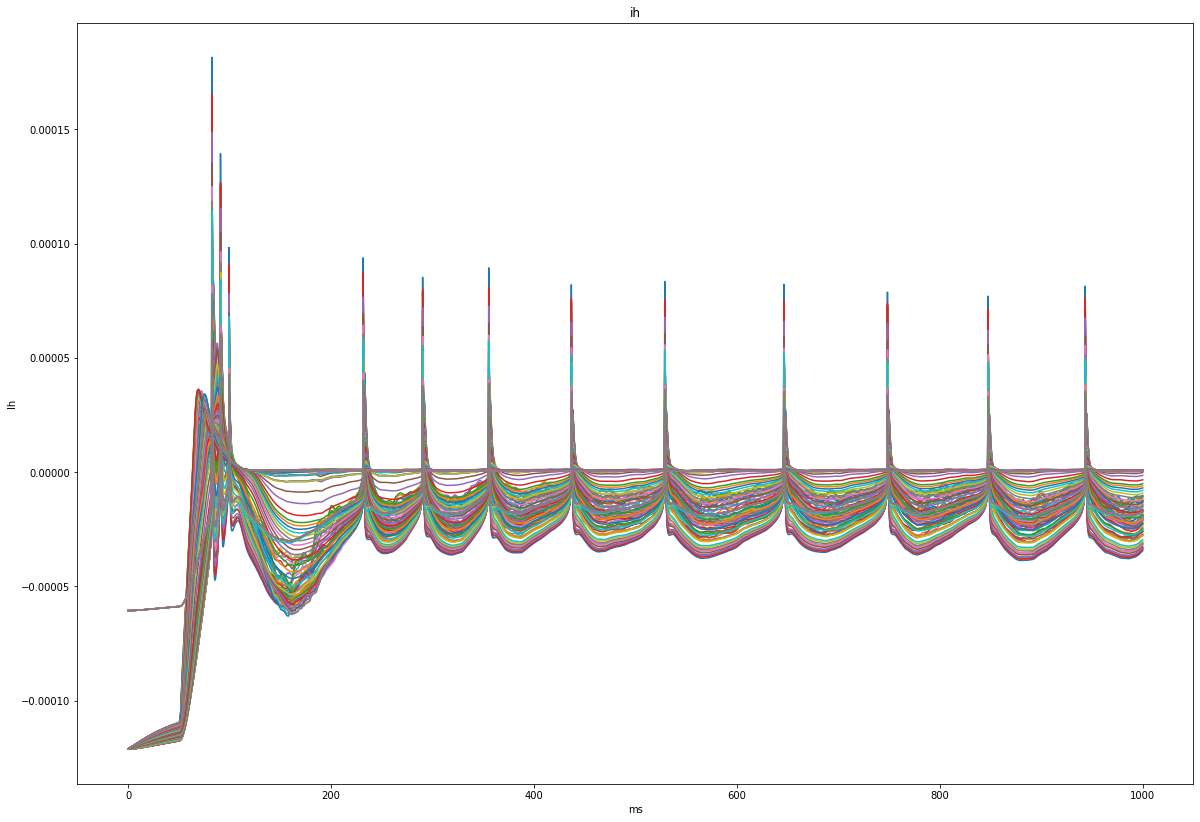

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline


# h current

plt.figure(figsize=(20,14))
for i in range(ih_data.shape[0]):
    plt.plot(t,ih_data[i,:])
    plt.title(Vrecord[i], loc='center')
    plt.ylabel('Ih')
    plt.xlabel('ms')
    plt.title('ih')
plt.show()

143


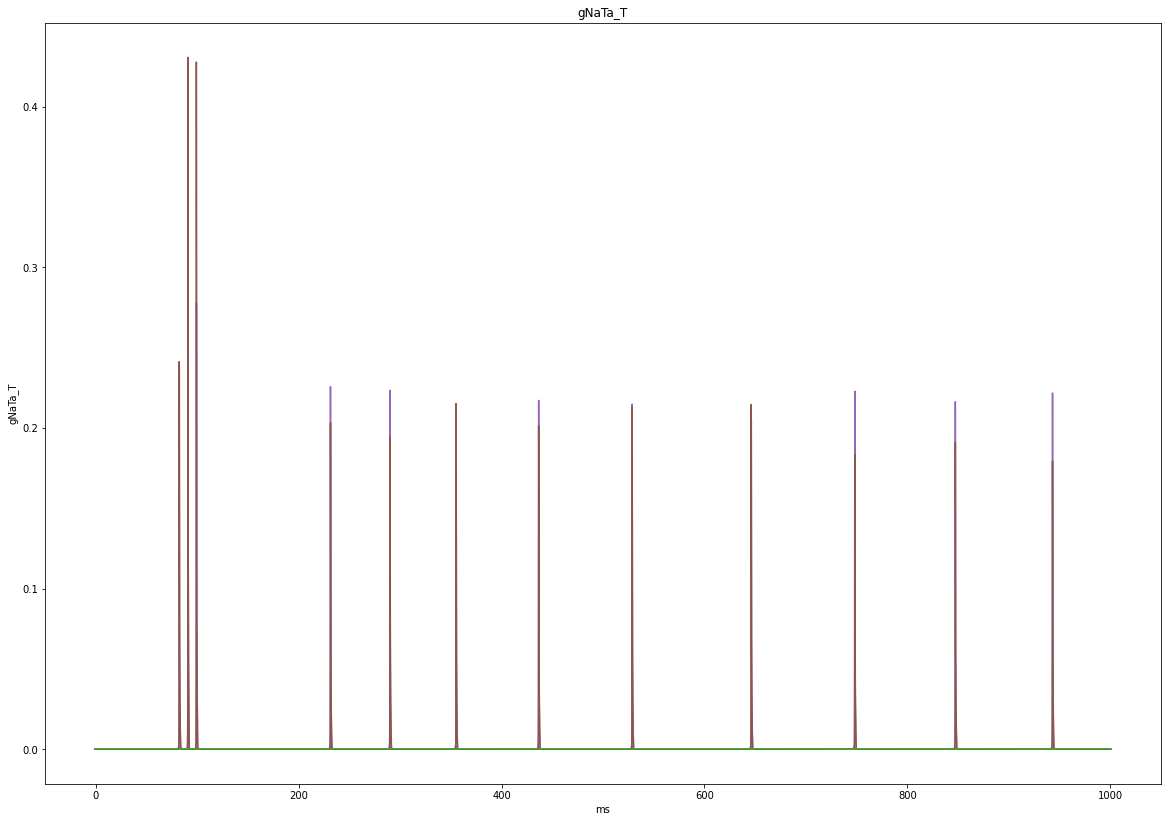

In [46]:
sec = []
for i in range(nseg-1):
  if AllSegSection[i] >= 11 :
    sec.append(i)

print(len(sec))



plt.figure(figsize=(20,14))
for i in sec:
    plt.plot(t,gNaTa_T_data[i,:])
    plt.title(gNaTa_T, loc='center')
    plt.ylabel('gNaTa_T')
    plt.xlabel('ms')
    plt.title('gNaTa_T')
plt.show()

# plt.figure(figsize=(20,14))
# for i in sec14:
#     plt.plot(t,gNaTa_T_data[i,:])
#     plt.title(gNaTa_T, loc='center')
#     plt.ylabel('gNaTa_T')
#     plt.xlabel('ms')
# plt.show()

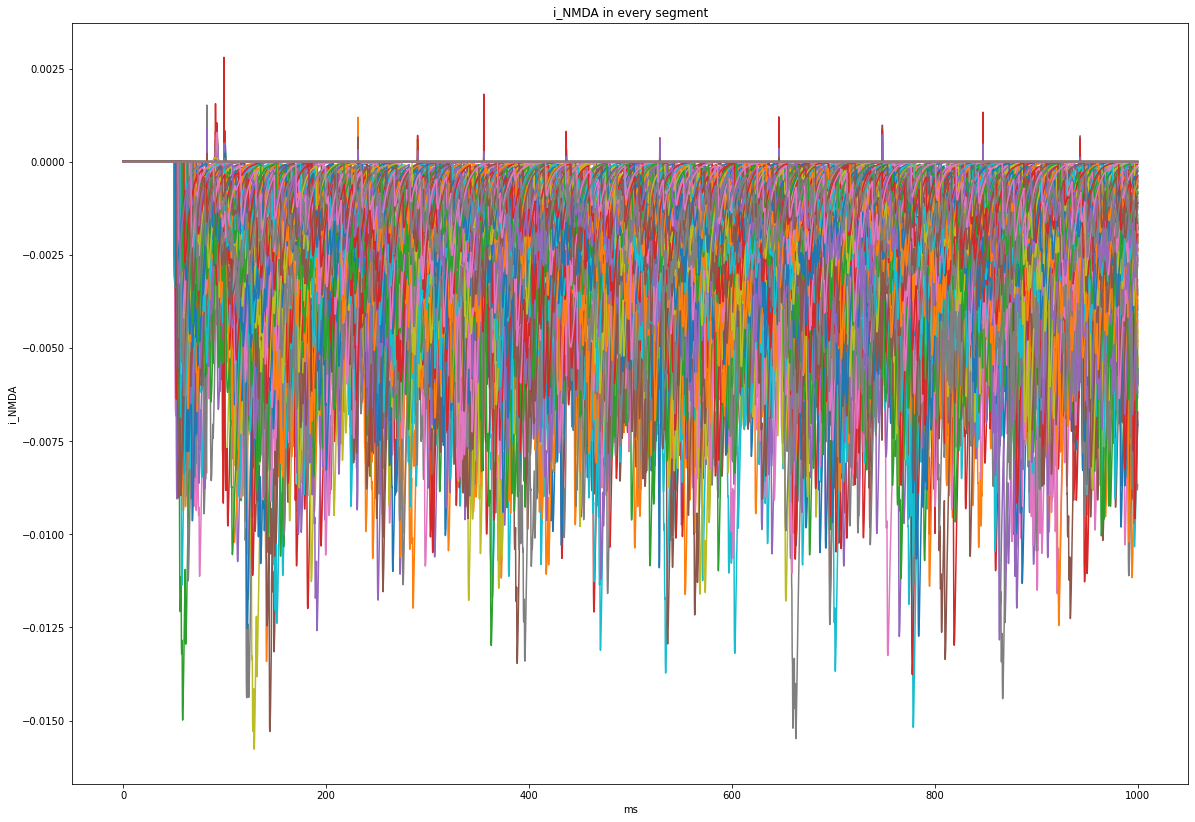

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline


#NMDA current 

plt.figure(figsize=(20,14))
for i in range(len(i_NMDA_bySeg)):
    plt.plot(t,i_NMDA_bySeg[i])
    plt.title(Vrecord[i], loc='center')
    plt.ylabel('i_NMDA')
    plt.xlabel('ms')
    plt.title('i_NMDA in every segment')
plt.show()

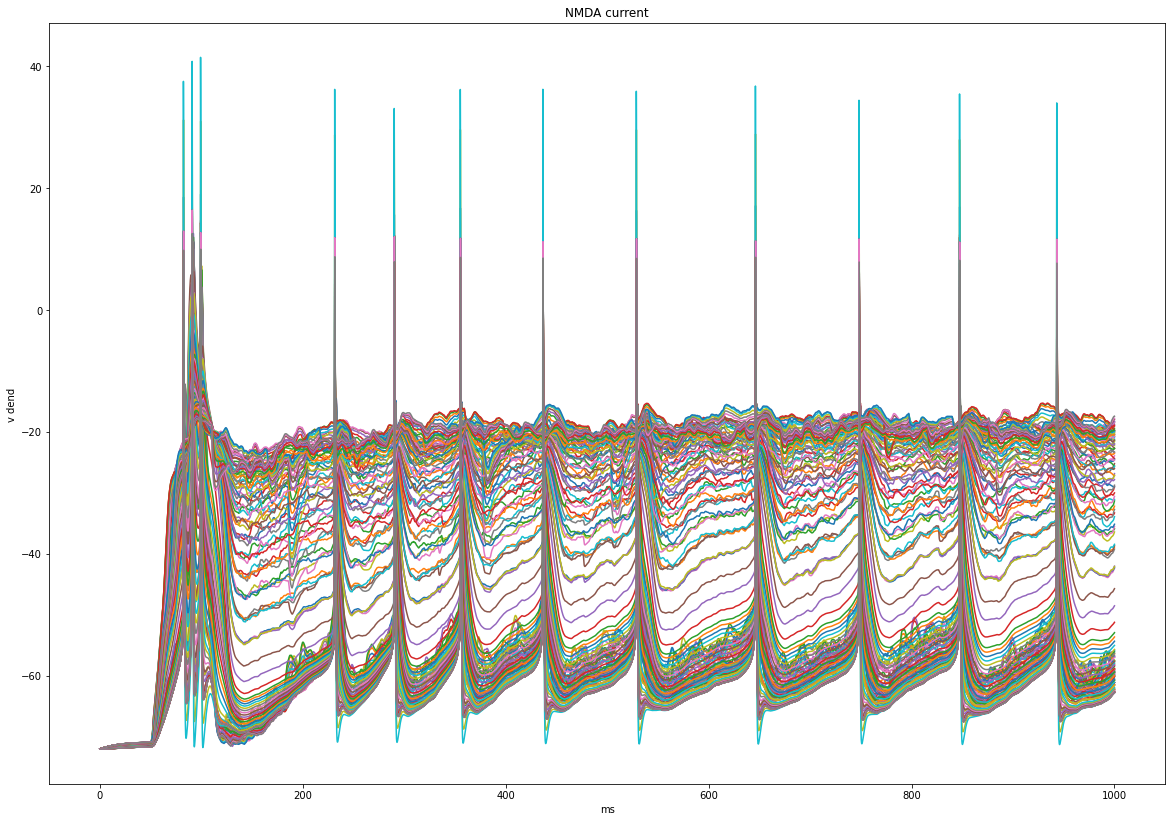

In [48]:



#NMDA current 

plt.figure(figsize=(20,14))
for i in range(len(v_dend)):
    plt.plot(t,v_dend[i])
    plt.title(Vrecord[i], loc='center')
    plt.ylabel('v dend ')
    plt.xlabel('ms')
    plt.title('NMDA current')
plt.show()